# Custom modules

In [1]:
import os
import sys
# Custom modules: add the 'lib' directory as one where we can import modules
# lib_src = os.path.join(os.getcwd(), os.pardir, 'src')
lib_src = '\\Users\\mauricio\\gdrive\\python\\machine-learning'
sys.path.insert(1, lib_src)

from model_selection.multilabel import multilabel_sample_dataframe, multilabel_train_test_split, sample_report, split_report, sample_split_report
from dummies import reverse_dummies, get_dummies_indices

# Standard data science modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Loading data

Sign up for an account on [DrivenData](http://www.drivendata.org/)  
Join the [Box-plots for education competition](https://www.drivendata.org/competitions/46/box-plots-for-education-reboot/)  
Download the competition datasets named `TrainingData.csv` and `TestData.csv`

In [3]:
df = pd.read_csv('../data/TrainingData.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        375493 non-null object
Text_2                    88217 non-null object
SubFund_Description       306855 non-null object
Job_Title_Description     292743 non-null object
Text_3                    109152 non-null object
Text_4                    53746 non-null object
Sub_Object_Description    91603 non-null object
Location_Description      162054 non-null object
FTE                       126071 non-null float64
Func

# Shuffling data

In machine learning theory, i.i.d. assumption is often made for training datasets to imply that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples.

To ensure observations are independent and don't follow any predefined sequence, the dataset is shuffled.

It's important when using the class `sklearn.model_selection.GridSearchCV` with k-fold cross-validation which doesn't resample the dataset as per the underlying class `sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=False, random_state=None)` doesn't shuffle data by default and that could lead to biased folds.

In [4]:
df = df.sample(frac=1, random_state=1)

# Encoding labels as category types

In [5]:
LABELS = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 'Sharing', 'Student_Type', 'Use']
FEATURES = [feature for feature in df.columns if feature not in LABELS]
print('Memory before enconding: {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))
df[LABELS] = df[LABELS].apply(lambda x: x.astype('category'), axis=0)
print('Memory after enconding : {:.1f} MB ({:.1f} MB deep)'.format(df.memory_usage().sum()/1024**2, df.memory_usage(deep=True).sum()/1024**2))

Memory before enconding: 79.4 MB (548.5 MB deep)
Memory after enconding : 55.4 MB (313.0 MB deep)


# Converting labels in dummy variables

In [6]:
# Converting labels in dummy variables
y = pd.get_dummies(df[LABELS], prefix_sep='__')
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 129752 to 189020
Columns: 104 entries, Function__Aides Compensation to Use__Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 42.8 MB


# Test 1: sklearn's train_test_split()

In [7]:
from sklearn.model_selection import train_test_split
try:
    X_train, X_test, y_train, y_test = train_test_split(df[FEATURES],
                                                        y,
                                                        test_size = 0.1,
                                                        random_state=1,
                                                        stratify=y)
except ValueError as err:
    print('ValueError:', err)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.


As pointed out in **_Groups of labels with less than 2 samples (unstratifiable)_**, the y population has class groups with less than 2 observations, thefore, the standard sklearn's `train_test_split()` won't work because of those cases.

# Test 2: Large sample multi_train_test_split()

Train size`: 360250
Test size  : 40027


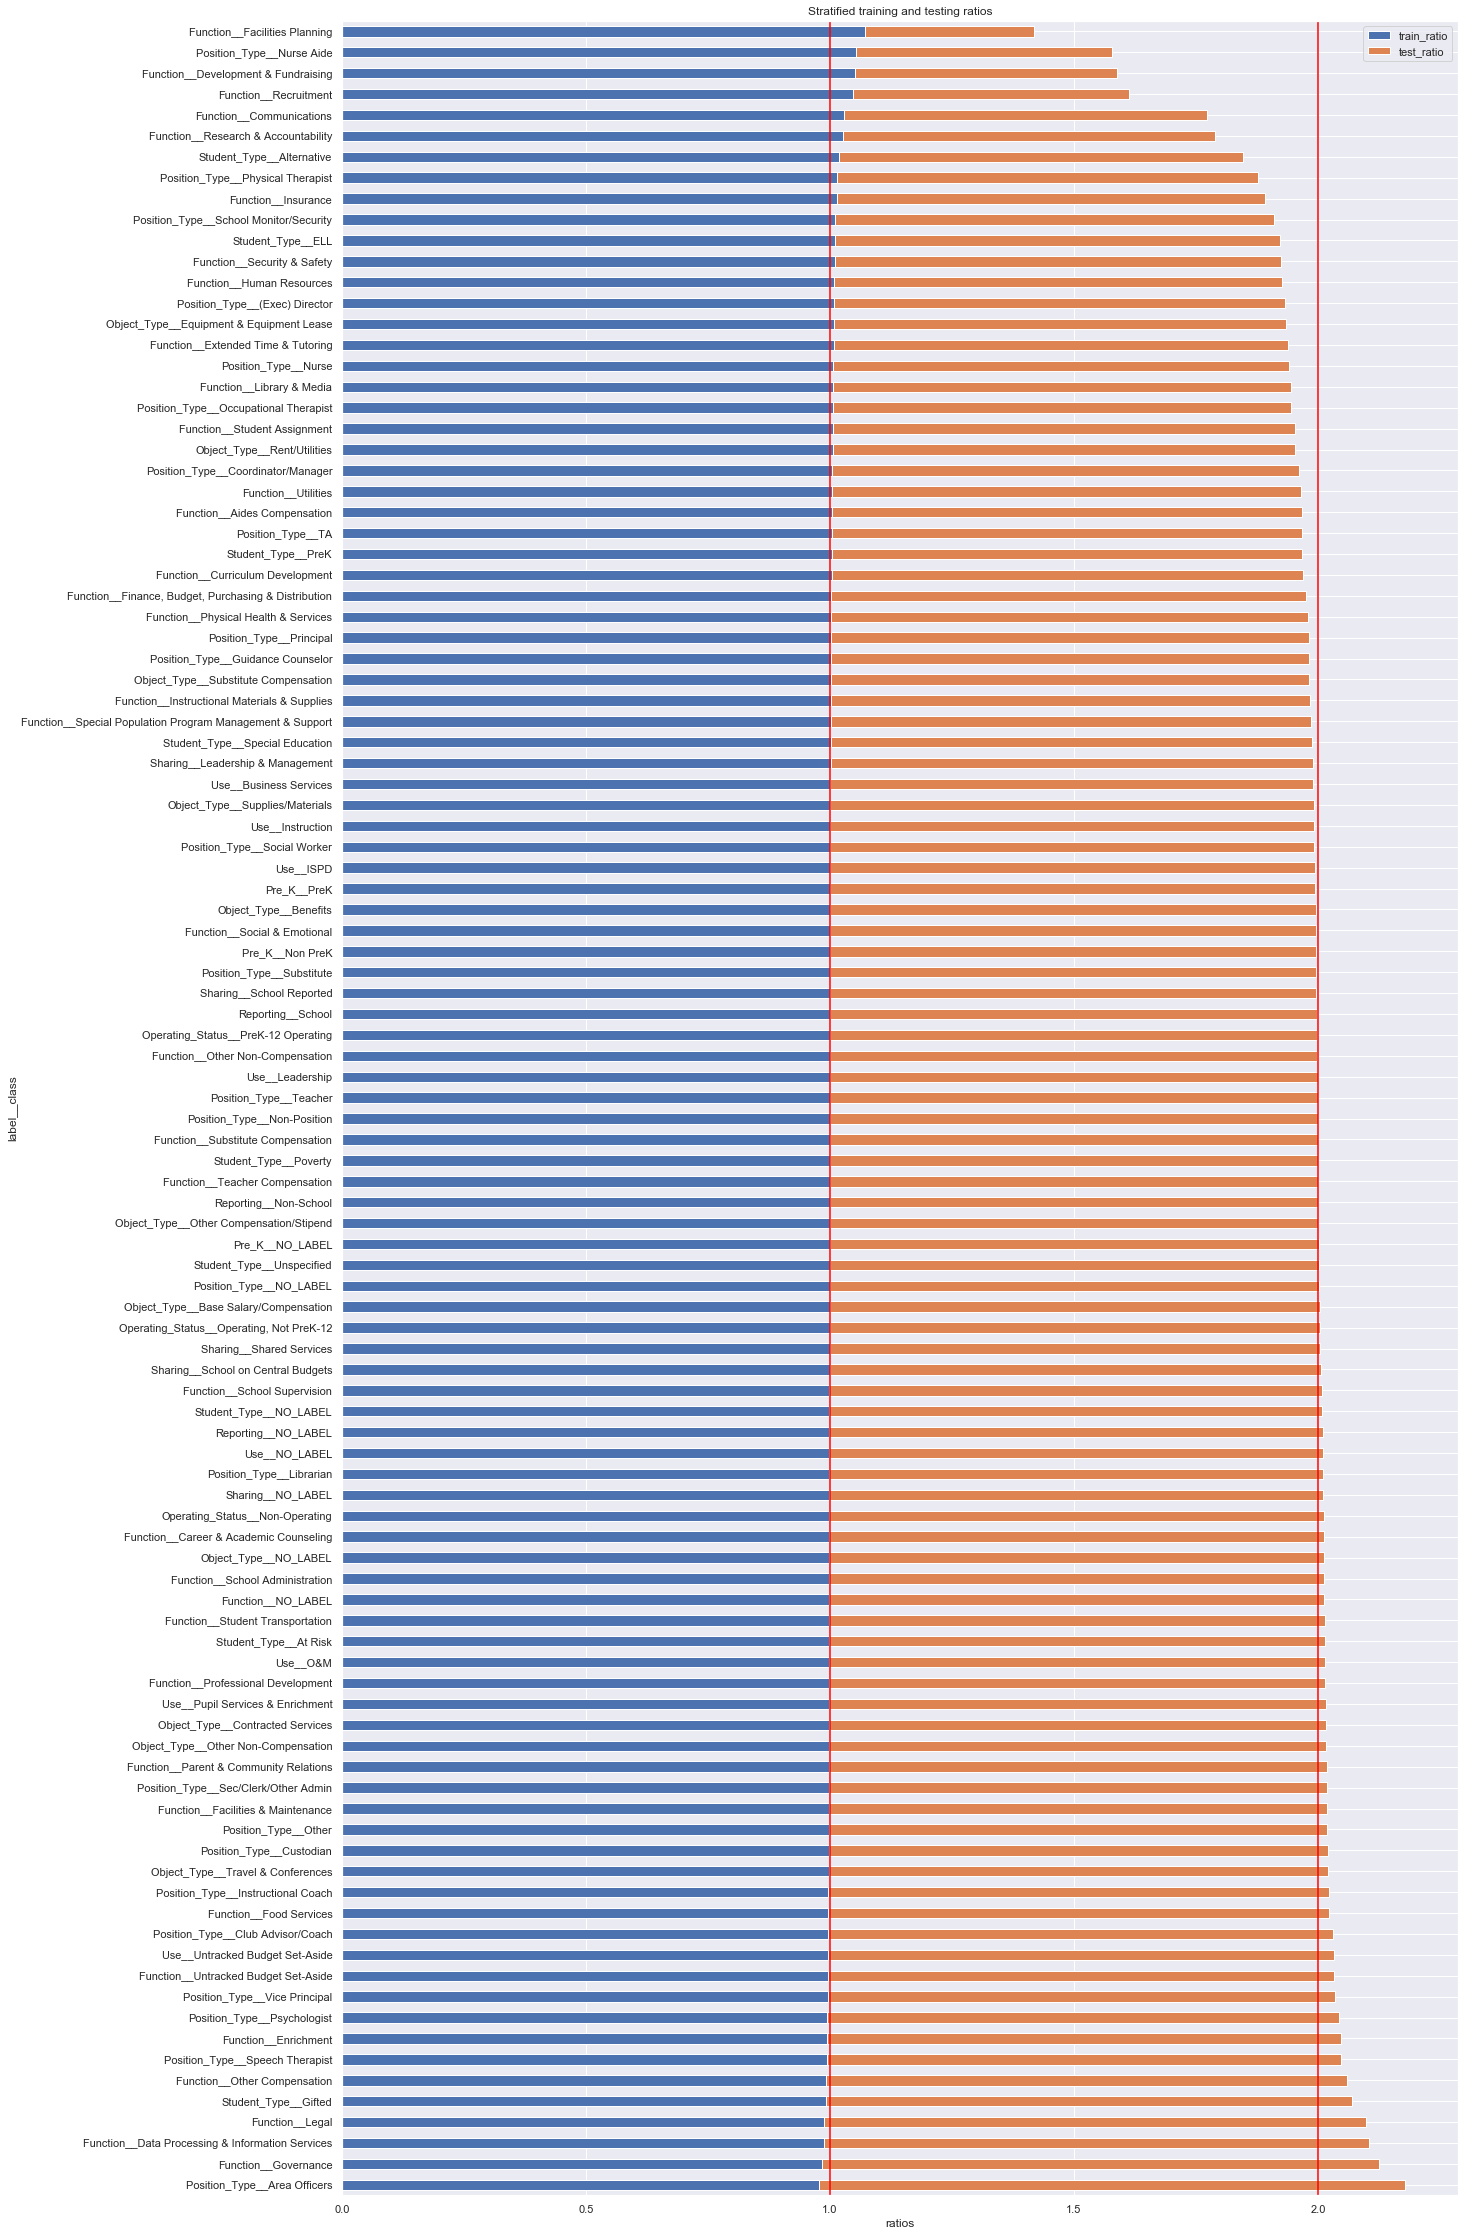

,train_ratio,test_ratio
label__class,,
Function__Facilities Planning,1.072795,0.344834
Position_Type__Nurse Aide,1.052630,0.526325
Function__Development & Fundraising,1.051372,0.537644
Function__Recruitment,1.048298,0.565312
Function__Communications,1.028527,0.743256
...,...,...
Student_Type__Gifted,0.991290,1.078389
Function__Legal,0.987652,1.111131
Function__Data Processing & Information Services,0.987005,1.116959


In [8]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[FEATURES],
                                                               y,
                                                               size=0.1,
                                                               min_count=0,
                                                               seed=1)
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])
split_report(y, y_train, y_test)

# Test 3: Small sample multi_train_test_split()

## Stratified sample

Sample size: 4002


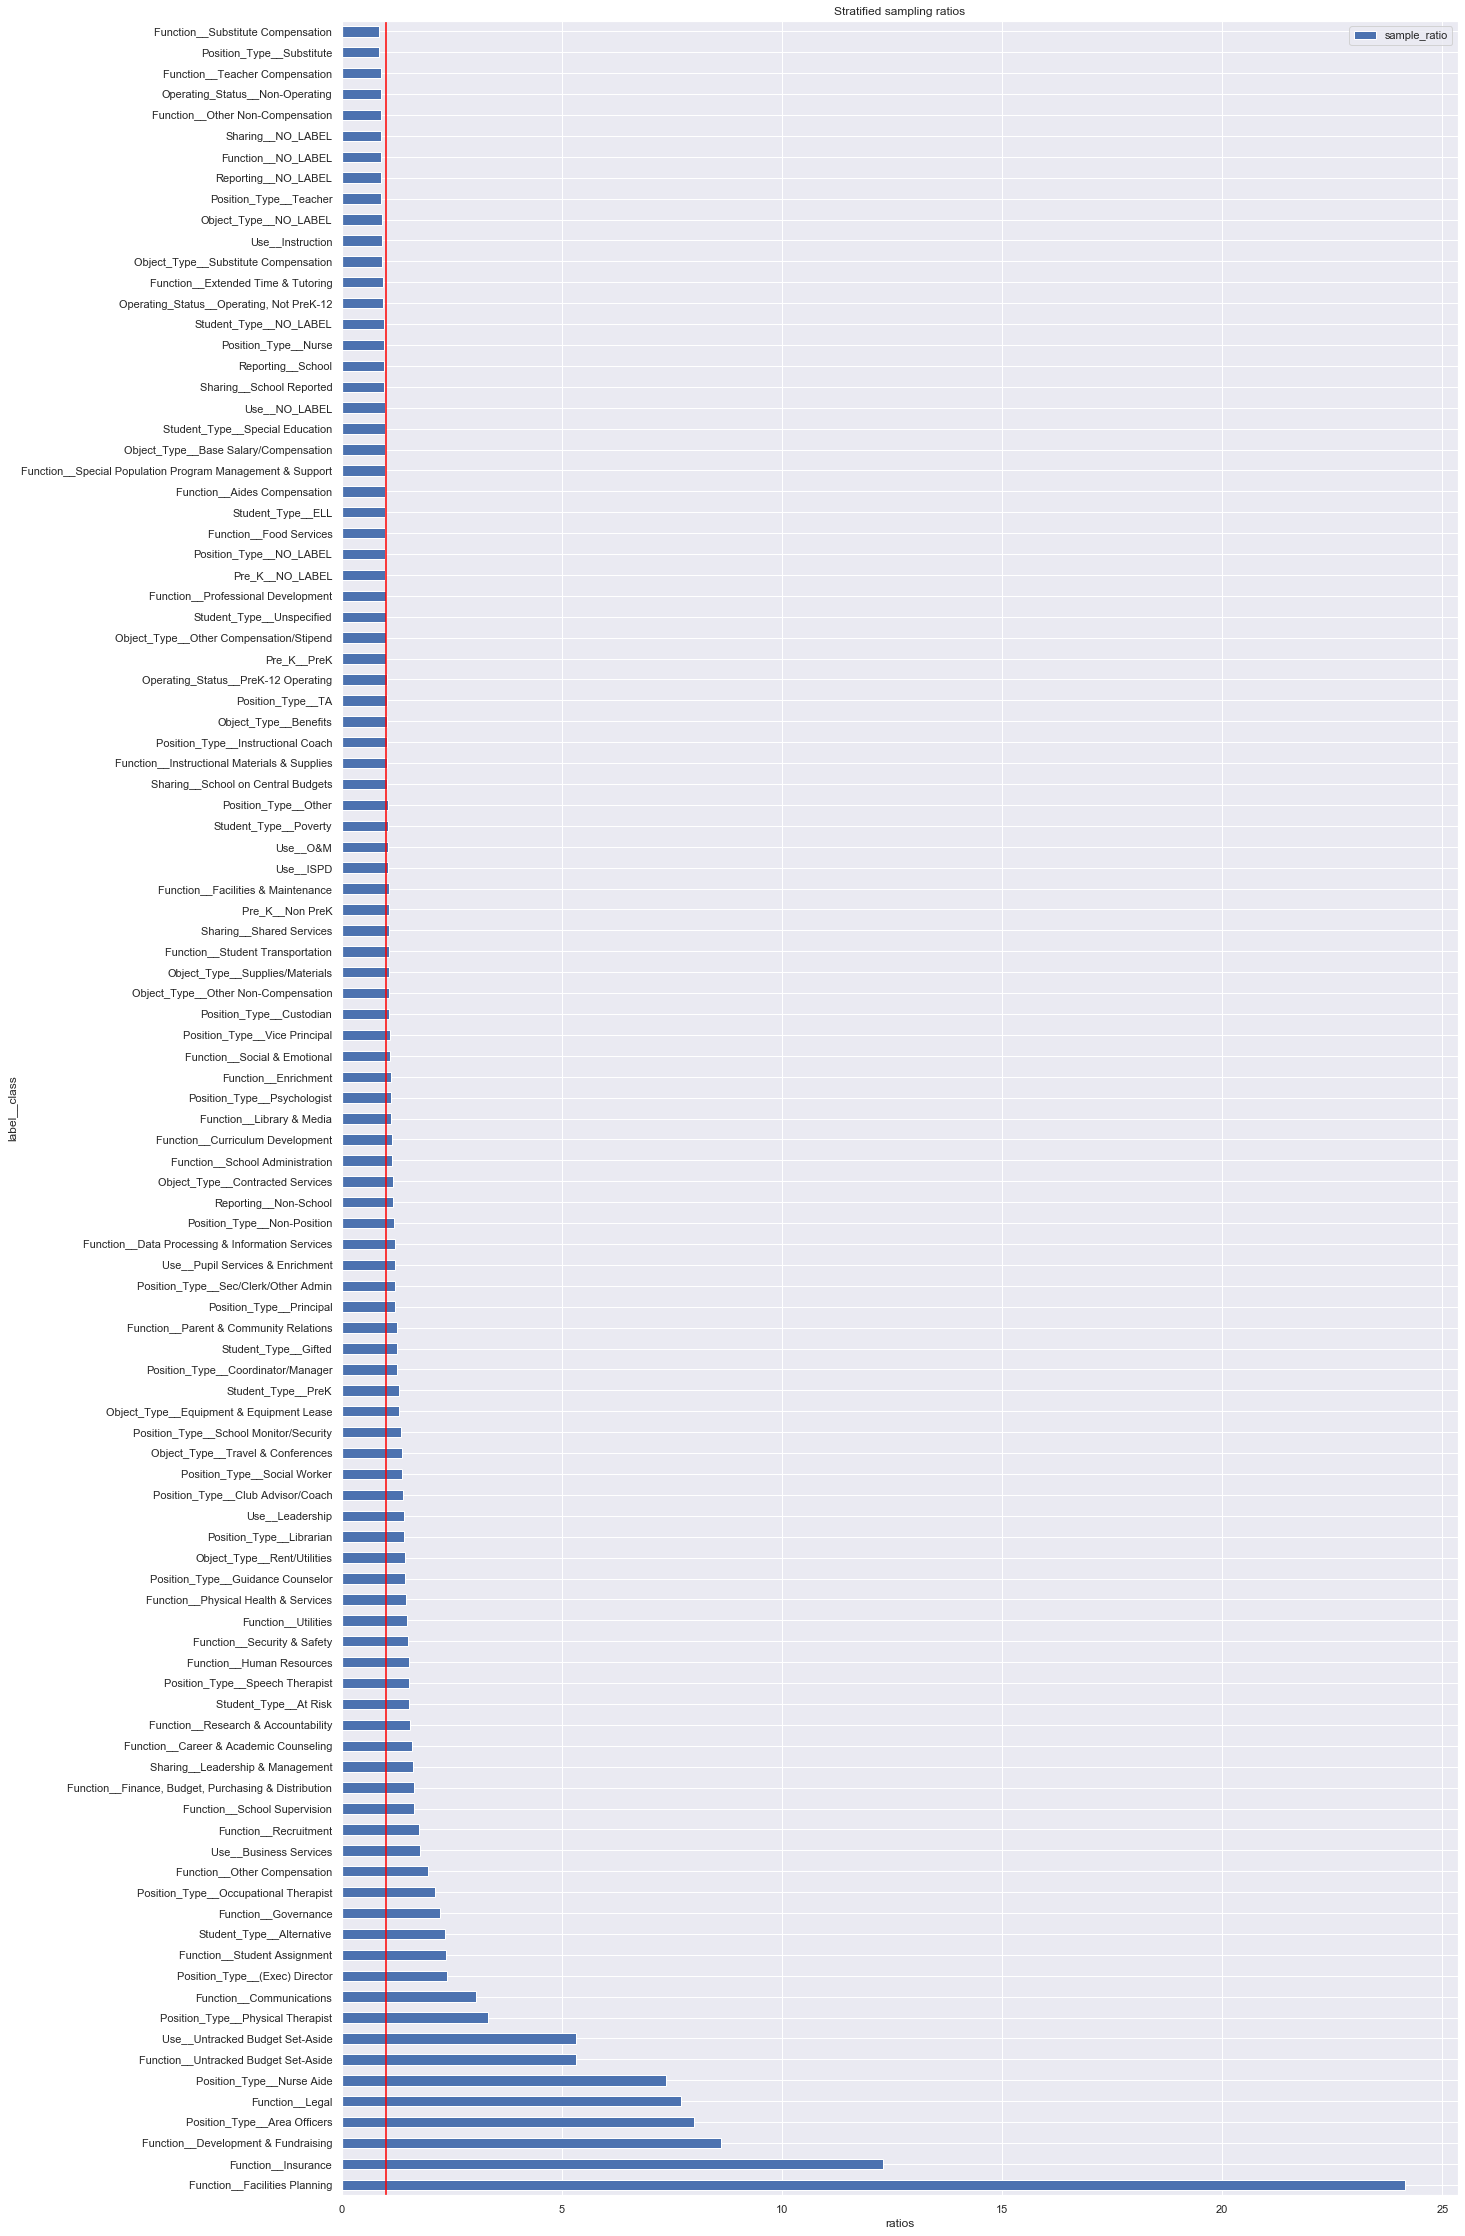

,sample_ratio
label__class,
Function__Substitute Compensation,0.844010
Position_Type__Substitute,0.851931
Function__Teacher Compensation,0.882584
Operating_Status__Non-Operating,0.882878
Function__Other Non-Compensation,0.887581
...,...
Function__Legal,7.693788
Position_Type__Area Officers,8.001539
Function__Development & Fundraising,8.603806


In [9]:
sampling = multilabel_sample_dataframe(df,
                                       y,
                                       size=0.01,
                                       min_count=7,
                                       seed=1)
dummy_labels = pd.get_dummies(sampling[LABELS], prefix_sep='__')
print('Sample size:', sampling.shape[0])
sample_report(y, dummy_labels)

## Stratified split of the stratified sample

Sample size: 4002
Train size`: 3602
Test size  : 400


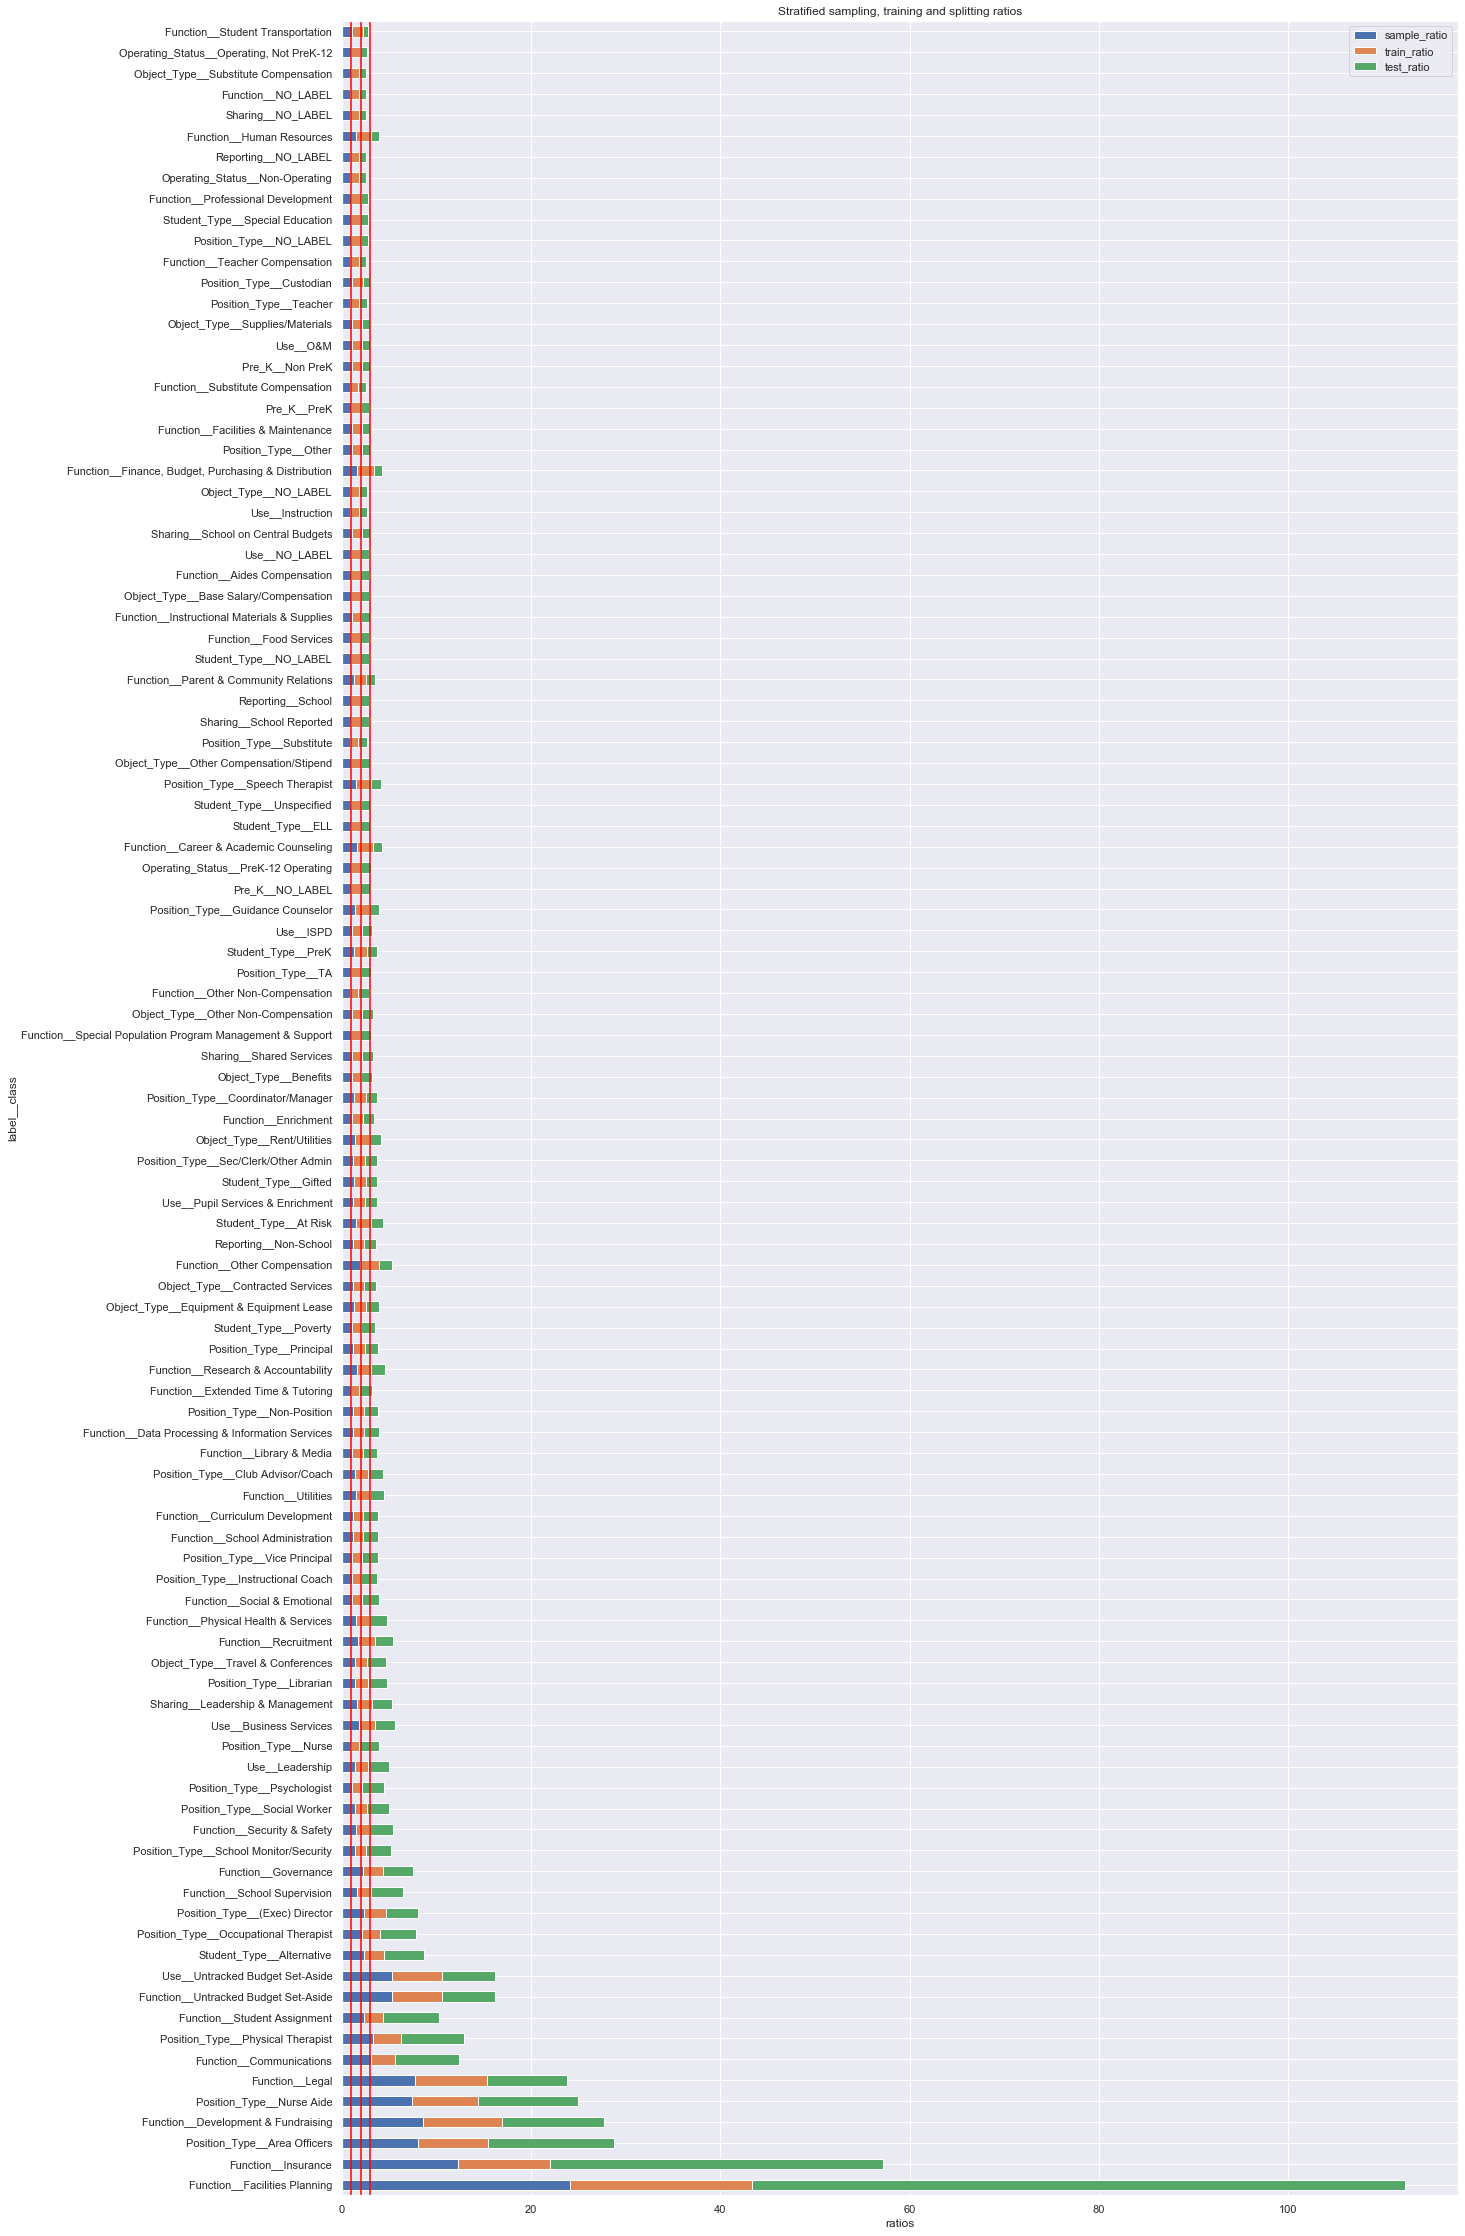

,sample_ratio,train_ratio,test_ratio
label__class,,,
Function__Student Transportation,1.071809,1.128971,0.557062
"Operating_Status__Operating, Not PreK-12",0.946518,0.974680,0.692920
Object_Type__Substitute Compensation,0.917675,0.938340,0.731581
Function__NO_LABEL,0.891425,0.906484,0.755823
Sharing__NO_LABEL,0.887735,0.902097,0.758407
...,...,...,...
Position_Type__Nurse Aide,7.369839,7.018504,10.533605
Function__Development & Fundraising,8.603806,8.364347,10.760134
Position_Type__Area Officers,8.001539,7.408421,13.342567


In [10]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(sampling[FEATURES],
                                                               dummy_labels,
                                                               size=0.1,
                                                               min_count=1,
                                                               seed=1)
print('Sample size:', sampling.shape[0])
print('Train size`:', y_train.shape[0])
print('Test size  :', y_test.shape[0])
sample_split_report(y, dummy_labels, y_train, y_test)

Here we see that some testing labels are missing after splitting.  
It's required to simultaneously optimize the `size` and `min_count` parameters on either `multilabel_sample_dataframe` and `multilabel_train_test_split`, thus, balancing the stratification the best possible to achieve the best ratio.

# Optimize sampling and splitting parameters

Run the script `optimize-sample-split.py` before continue

In [7]:
import pickle
if os.path.isfile('../data/optimize-sample-split.pkl'):
    with open('../data/optimize-sample-split.pkl', 'rb') as f:
        results = pickle.load(f)
else:
    print('Please run the optimize-sample-split.py')
    exit

# Drop rows containing NaN or Infinite
print('original', results.shape)
results = results.replace([np.inf, -np.inf], np.nan).dropna()
print('after drop nan/inf', results.shape)

# Convert ratios to indices starting from zero
results['sample_index'] = np.abs(results.sample_ratio - 1)
results['train_index'] = np.abs(results.train_ratio - 1)
results['test_index'] = np.abs(results.test_ratio - 1)

original (102528, 10)
after drop nan/inf (102528, 10)


# Best parameters decision

* For begining the model, the parameter set should result in:
    * The smallest sample size (e.g. 0.1)
    * The smallest test size (e.g. 0.1)
    * The best stratified sample (sample_index) and split (train_index and test_index)
* For finishing the model, the parameter set should have:
    * The full dataset with not stratify intervention (sample size 1.0 sample min count 0)
    * The smallest test size (e.g. 0.1)
    * The best stratified split (train_index and test_index)
    * The minimum stratify intervention (split min count ~0)
* Both parameter sets should support a minimum of the desired k classes for `GridSearchCV`/`StratifedKFold`
* The k-folding is limited by the population less frequent class:
    * The train less frequent class should at least k.
    * The test less frequent class should at least 1.
    * The sample less frequent class is implied to at least k+1.

## For begining the model

At desired k-folds, smallest sample, 20% test size, best indices

In [12]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
261,0.01,7.0,0.2,1.0,5.0,1.0,0.867267,0.748957,1.340806
416,0.01,9.0,0.2,1.0,5.0,1.0,1.176023,0.985457,1.938764
435,0.01,9.0,0.4,0.0,5.0,1.0,1.176023,1.135874,1.236296


At desired k-folds, 10% sample size, 20% test sizes, best indices

In [20]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
9566,0.3,0.0,0.2,0.0,5.0,1.0,0.004882,0.004896,0.004830
9567,0.3,0.0,0.2,1.0,6.0,1.0,0.004882,0.006562,0.001835
9568,0.3,0.0,0.2,2.0,5.0,2.0,0.004882,0.013288,0.028742


At max k folds, smallest sample size, 20% test size, best indices

In [14]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
834,0.01,13.0,0.2,1.0,9.0,1.0,1.675393,1.571538,2.091076
960,0.01,14.0,0.2,0.0,10.0,1.0,1.854427,1.869425,1.794399
961,0.01,14.0,0.2,1.0,9.0,2.0,1.854427,1.695938,2.488780


At max k folds, 10% sample size, 20% test size, best indices

In [15]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1)
        & (results.sample_size==0.1) & (results.test_size >= .2)
       ].sort_values(['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'sample_index', 'train_index', 'test_index'
                     ])[['sample_size', 'sample_min_count', 'test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,sample_size,sample_min_count,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
850,0.1,11.0,0.2,0.0,11.0,1.0,0.126611,0.132878,0.101541
863,0.1,11.0,0.3,0.0,9.0,3.0,0.126611,0.136526,0.103477
968,0.1,12.0,0.2,0.0,10.0,2.0,0.135482,0.129456,0.159591


## For finishing the model

At desired k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [18]:
k = 5
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
55407,0.2,0.0,27.0,2.0,0.0,0.002664,0.010656
55408,0.2,1.0,20.0,9.0,0.0,0.004614,0.018456
55409,0.2,2.0,21.0,8.0,0.0,0.003389,0.013556


At max k-folds, 100% data with no stratify intervention, 20% test size with mininum stratify intervention and best indices

In [17]:
k = np.floor(y.sum().min() / 3)
print('Max k-folding:', k)
results[(results.train_lessfreq >= k) & (results.test_lessfreq >= 1) &
        (results.sample_size==1) & (results.sample_min_count==0) & (results.test_size >= .2)
       ].sort_values(['test_size', 'test_min_count', 'train_index', 'test_index']
                    )[['test_size', 'test_min_count', 'train_lessfreq', 'test_lessfreq', 'sample_index', 'train_index', 'test_index']].head(3)

Max k-folding: 9.0


,test_size,test_min_count,train_lessfreq,test_lessfreq,sample_index,train_index,test_index
55407,0.2,0.0,27.0,2.0,0.0,0.002664,0.010656
55408,0.2,1.0,20.0,9.0,0.0,0.004614,0.018456
55409,0.2,2.0,21.0,8.0,0.0,0.003389,0.013556
